In [1]:
library(rstan)
library(brms)
library(here)
library(ggplot2)

# 計算の高速化
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


要求されたパッケージ StanHeaders をロード中です


rstan version 2.32.6 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


要求されたパッケージ Rcpp をロード中です

Loading 'brms' package (version 2.21.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


次のパッケージを付け加えます: ‘brms’


以下のオブジェクトは ‘package:rstan’ からマスクされています:

    loo


以下のオブジェクトは ‘package:stats’ からマスクされています:

    ar


here() starts at /media/e595/Game/プロジェクト置き場/RとStanで始めるベイズ統計モデリング



In [2]:
germination_dat <- read.csv(here("data", "3-9-1-germination.csv"))
head(germination_dat, n = 3)


,germination,size,solar,nutrition
,<int>,<int>,<chr>,<int>
1,0,10,shade,1
2,0,10,shade,1
3,0,10,shade,1


In [3]:
summary(germination_dat)


  germination         size       solar             nutrition   
 Min.   : 0.00   Min.   :10   Length:100         Min.   : 1.0  
 1st Qu.: 0.00   1st Qu.:10   Class :character   1st Qu.: 3.0  
 Median : 1.00   Median :10   Mode  :character   Median : 5.5  
 Mean   : 2.83   Mean   :10                      Mean   : 5.5  
 3rd Qu.: 4.00   3rd Qu.:10                      3rd Qu.: 8.0  
 Max.   :10.00   Max.   :10                      Max.   :10.0  

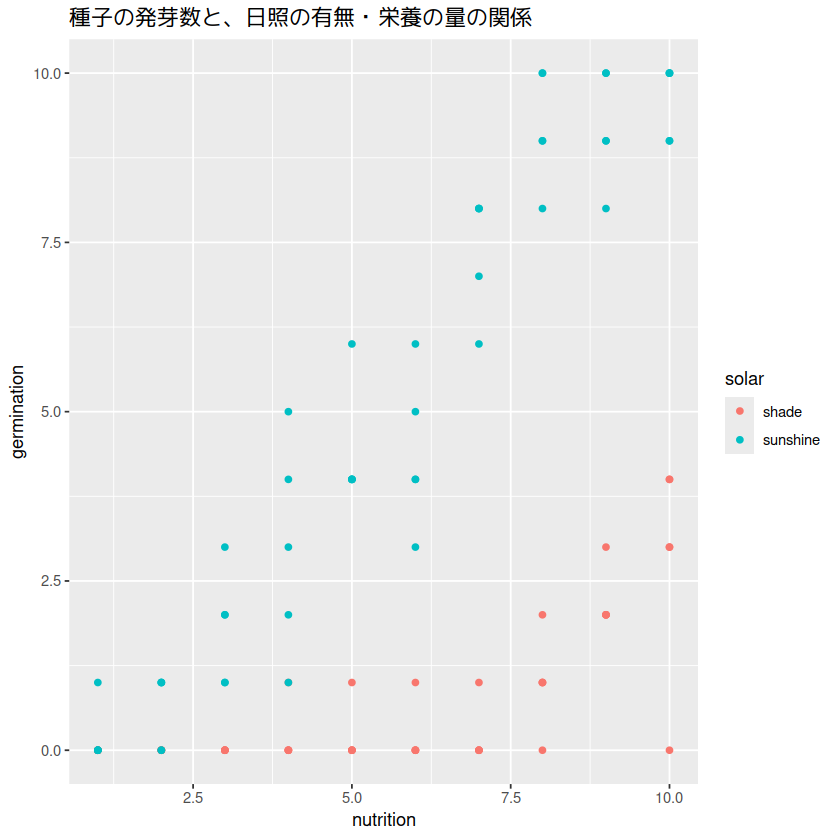

In [4]:
ggplot(
  data = germination_dat,
  mapping = aes(x = nutrition, y = germination, color = solar)
) +
  geom_point() +
  labs(title = "種子の発芽数と、日照の有無・栄養の量の関係")


In [28]:
glm_binom_brms <- brm(
  germination | trials(size) ~ solar + nutrition,
  family = binomial(),
  data = germination_dat,
  seed = 1,
  prior = c(set_prior("", class = "Intercept"))
)


Compiling Stan program...

recompiling to avoid crashing R session

Start sampling



In [22]:
glm_binom_brms


 Family: binomial 
  Links: mu = logit 
Formula: germination | trials(size) ~ solar + nutrition 
   Data: germination_dat (Number of observations: 100) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -8.03      0.52    -9.09    -7.08 1.00     1349     1271
solarsunshine     4.05      0.29     3.49     4.64 1.00     1736     2069
nutrition         0.72      0.06     0.62     0.83 1.00     1573     1591

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

In [11]:
# 説明変数を作る
newdata_1 <- data.frame(
  solar = c("shade", "sunshine", "sunshine"),
  nutrition = c(2, 2, 3),
  size = c(10, 10, 10)
)


In [12]:
# 線形予測子の予測値
linear_fiit <- fitted(glm_binom_brms, newdata_1, scale = "linear")[, 1]
fit <- 1 / (1 + exp(-linear_fiit))
fit


[1] 0.001379165 0.073597932 0.140366311

In [14]:
# オッズを計算
odds_1 <- fit[1] / (1 - fit[1])
odds_2 <- fit[2] / (1 - fit[2])
odds_3 <- fit[3] / (1 - fit[3])


In [16]:
# モデルの数を取得
coef <- fixef(glm_binom_brms)[, 1]
coef


Intercept solarsunshine     nutrition 
   -8.0257777     4.0522051     0.7204406

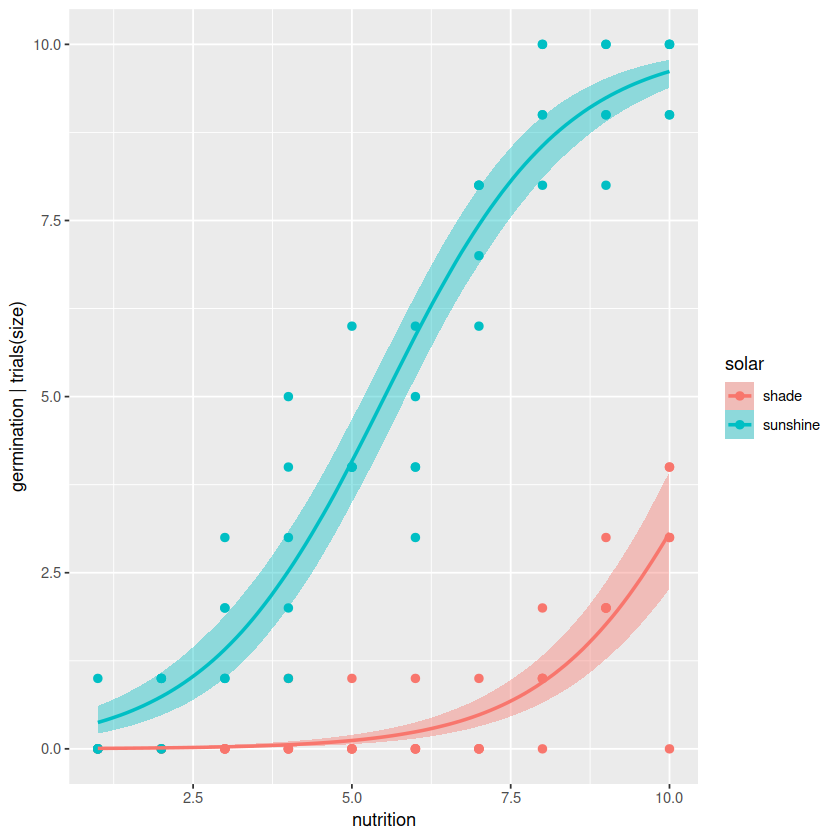

In [29]:
eff <- conditional_effects(glm_binom_brms,
  effects = "nutrition:solar",
  conditions = data.frame(size = 10)
)

plot(eff, points = TRUE)
